## Outlier Detection using Statistical Methods


* point outliers - a data point that deviates from the rest of the population
* collective outliers - groups of observations, differ from the population and don't follow the expected pattern
* contextual outliers - when an observation is considered an outlier based on a particular condition or context, such as deviation from neighboring data points

_Change Point Detection (CPD)_:
 - relates to outlier detection
 - the goal is to anticipate abrupt and impactful fluctuations in the time series data 
 
 CPD covers specific techniques, for example:
  * cumulative sum (CUSUM)
  * Bayesian online change point detection (BOCPD)

This chapter will walk through:
* Resampling time series data 
* Detecting outliers using visualizations 
* Detecting outliers using the Tukey method 
* Detecting outliers using a z-score 
* Detecting outliers using a modified z-score

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from pathlib import Path 
import warnings 
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [16, 3]

In [4]:
file = Path("../TimeSeriesAnalysisWithPythonCookbook/Data/nyc_taxi.csv")
nyc_taxi = pd.read_csv(file, index_col='timestamp', parse_dates=True)
nyc_taxi.index.freq = '30T'

In [6]:
# Store the known dates containing outliers, also known as ground truth labels 
nyc_dates = [
    '2014-11-01', 
    '2014-11-27',
    '2014-12-25',
    '2014-01-01',
    '2014-01-27',
]


<AxesSubplot:title={'center':'NYC Taxi'}, xlabel='timestamp'>

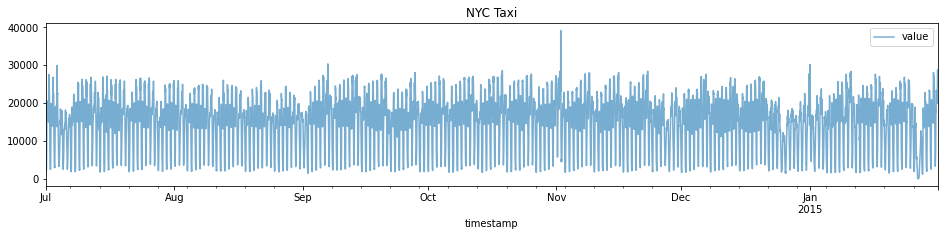

In [7]:
# We can plot the time series data to gain an intuition on the data we will be working with for our outlier detection
nyc_taxi.plot(title="NYC Taxi", alpha=0.6)

In [8]:
# Create a plot_outliers function that we will use repeatedly

def plot_outliers(outliers, data, method='KNN', 
                  halignment = 'right', 
                  valignment = 'bottom', 
                  labels = False):
    ax = data.plot(alpha=0.6)

    if labels:
        for i in outliers['value'].items():
            plt.plot(i[0], i[1], 'rx')
            plt.text(i[0], i[1], f'{i[0].date()}', 
                     horizontalalignment=halignment, 
                     verticalalignment=valignment)
    else: 
        data.loc[outliers.index].plot(ax=ax, style='rx')

    plt.title(f'NYC Taxi - {method}')
    plt.xlabel('date'); plt.ylabel('# of passengers')
    plt.legend(['nyc taxi', 'outliers'])
    plt.show()

## Understanding Outliers 

#### Resampling time series data 

 - a typical transformation that is done on time series data is resampling
 - the process implies changing the frequency or level of granularity of the data
 
 Downsampling
 - for instance going from daily data to weekly data
 - when downsampling we will need to do some level of aggregation, such as mean, sum, min or max

 Upsampling:
 - for instance going from daily to hourly
 - when upsampling we will end up with null rows, which we must fill either using imputation or interpolation techniques
 

In [10]:
# Downsample the data to a daily frequency
# resampling is done using the DataFrame.resample() function
# For daily, we will use 'D' as the date offset rule, followed by .mean()

df_downsampled = nyc_taxi.resample('D').mean()
df_downsampled

,value
timestamp,
2014-07-01,15540.979167
2014-07-02,15284.166667
2014-07-03,14794.625000
2014-07-04,11511.770833
2014-07-05,11572.291667
...,...
2015-01-27,4834.541667
2015-01-28,12947.562500
2015-01-29,14686.145833


In [11]:
# inspect the first DatetimeIndex to check its frequency
df_downsampled.index[0]


Timestamp('2014-07-01 00:00:00', freq='D')

In [12]:
# We can also check frequency directly using the .freq property
df_downsampled.index.freq

<Day>

In [13]:
# Check the number of records now after downsampling 
df_downsampled.shape 

(215, 1)

In [15]:
# Resample the data again, but this time as a 3-day frequency
# We can do this by using '3D'
# This time use the .sum() method instead 
df_downsampled = nyc_taxi.resample('3D').sum()
df_downsampled.head()

,value
timestamp,
2014-07-01,2189749
2014-07-04,1658320
2014-07-07,2111672
2014-07-10,2335629
2014-07-13,2139711


In [16]:
# Check the frequency of DatetimeIndex 
df_downsampled.index.freq

<3 * Days>

In [18]:
# Now change the frequency to 3 business days instead
df_downsampled = nyc_taxi.resample('3B').sum()
df_downsampled.head()

,value
timestamp,
2014-07-01,2189749
2014-07-04,3021425
2014-07-09,3799847
2014-07-14,2174540
2014-07-17,3711232


In [19]:
# Upsample the data from a 30-minute interval to a 15-minutes frequency
# This will create an empty entry (NaN) between every other entry
# We will use 'T' for minutes, since 'M' is used for monthly aggregation

nyc_taxi.resample('15T').mean().head()

#Notice that upsampling creates NaN rows. Unlike downsampling, when upsampling we need to give instructions 
# on how to fill the NaN rows



,value
timestamp,
2014-07-01 00:00:00,10844.0
2014-07-01 00:15:00,NaN
2014-07-01 00:30:00,8127.0
2014-07-01 00:45:00,NaN
2014-07-01 01:00:00,6210.0


In [20]:
# We can supply more than one aggregation at once when downsampling using the .agg() function
# For example using 'M' for monthly, we can supply the .agg() function with a list of aggregations we want to perform
nyc_taxi.resample('M').agg(['mean', 'min', 'max', 'median', 'sum'])


value                                
                    mean   min    max   median       sum
timestamp                                               
2014-07-31  14994.084677  1769  29985  16625.5  22311198
2014-08-31  14580.438844  1841  26062  16184.0  21695693
2014-09-30  15623.374306  1431  30373  17244.5  22497659
2014-10-31  16086.851478  1691  28626  17767.5  23937235
2014-11-30  15492.125000  1683  39197  17287.0  22308660
2014-12-31  14813.428763  1459  27804  16587.0  22042382
2015-01-31  14399.790995     8  30236  16061.0  21426889

## Detecting outliers using visualizations 

* Parametric: assume we know the underlying distribution of the data 
* Non-parametric: we can make no assumptions about the underlying distributon 

Using histograms and box-plots are basic non-parametric techniques that can provide insight into the distribution of the data and the presence of outliers. 


In [21]:
import seaborn as sns 


In [22]:
sns.__version__

'0.11.2'

In [23]:
# Downsample the data to a daily frequency 
tx = nyc_taxi.resample('D').mean()


In [25]:
# Plot the new tx DataFrame with the ground truth labels to use as a reference
nyc_dates_new = [
    '2014-11-01', 
    '2014-11-27',
    '2014-12-25',
]

known_outliers = tx.loc[nyc_dates_new]


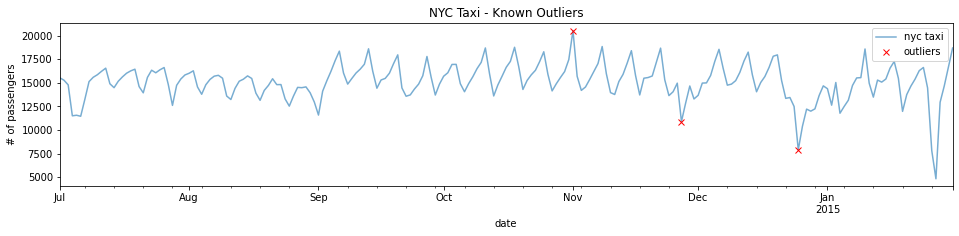

In [26]:
plot_outliers(known_outliers, tx, 'Known Outliers')

<AxesSubplot:ylabel='Count'>

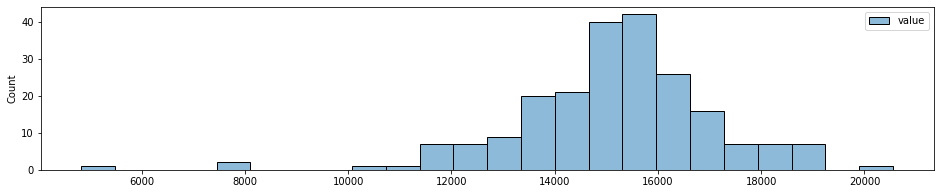

In [27]:
# First plot for inspecting our time series data using the histplot() function
sns.histplot(tx)

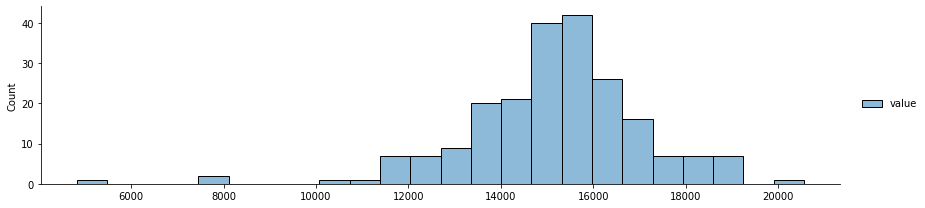

In [28]:
# Using a distplot()
# - distplot() takes a "kind" parameter that can take one of three values: 
# hist for histogram 
# kde for kernel density estimate plot 
# ecdf for empirical cumulative distribution plot

sns.displot(tx, kind='hist', height=3, aspect=4)

<AxesSubplot:xlabel='value'>

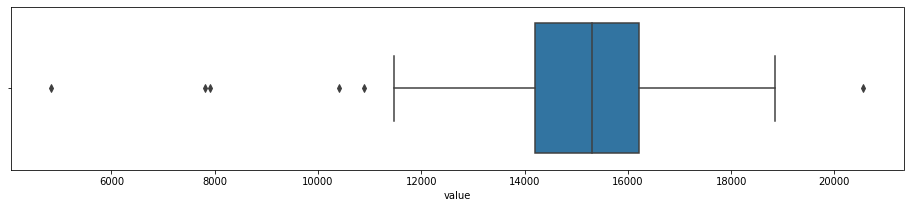

In [29]:
# Box-Plot
# - provides more information that a histogram and can be a better choice for spotting outliers
# - observations that are outside the whiskers or boundaries are considered outliers
# - the whiskers represents the visual boundary for the upper and lower fences
# - the width of the box is called the interquartile range (IQR) (the difference between the 75th and 25th percentile)
# - The lower fence is calculated as: Q1 - (1.5*IQR) and upper fence: (Q3 + (1.5*IQR))
# - any observation less than the lower boundary or greater than the upper boundary is considered a potential outlier
 

sns.boxplot(tx['value'])

<AxesSubplot:xlabel='value'>

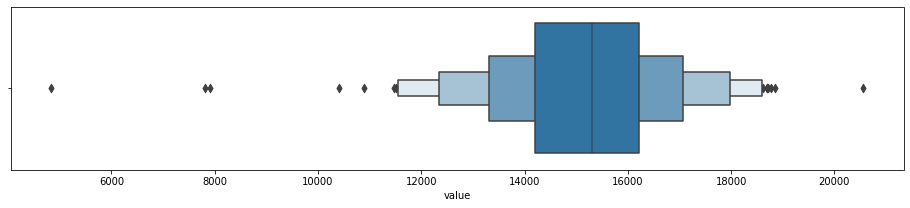

In [30]:
# There are two more variations for box plots
# - boxenplot: better suited when working with larger datasets 

sns.boxenplot(tx['value'])

<AxesSubplot:xlabel='value'>

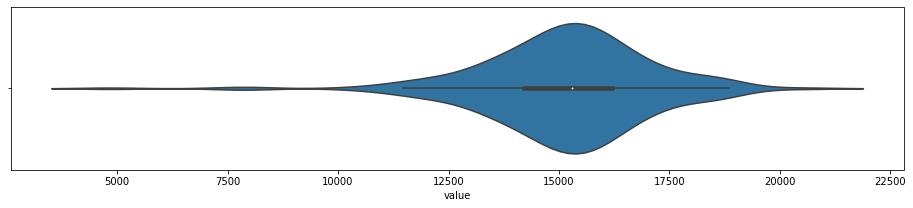

In [31]:
# The final variant is a violinplot
# - a hybrid between a box plot and a kernel density distribution
# - a kernel is a function that estimates the probability density function

sns.violinplot(tx['value'])

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

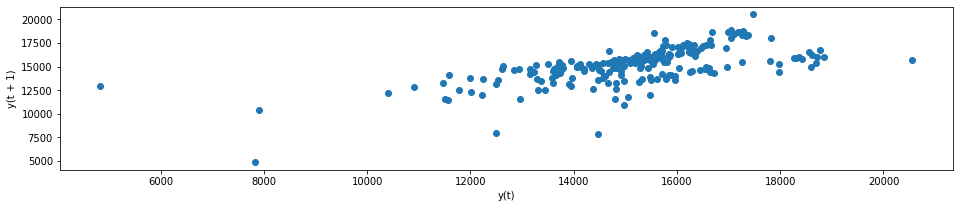

In [32]:
# The lag plot
# - essentially a scatter plot, plotting the same variable against its lagged values
# y axis will show time_t obs., and x axis will show time_t-1 obs

from pandas.plotting import lag_plot
lag_plot(tx)

## Detecting outliers using the Tukey method 

In [35]:
# Output summary statistics 
percentiles = [0, 0.05, 0.10, .25, .5, .75, .90, .95, 1]
tx.describe(percentiles=percentiles)

,value
count,215.000000
mean,15137.569380
std,1937.391020
min,4834.541667
0%,4834.541667
5%,11998.181250
10%,13043.854167
25%,14205.197917
50%,15299.937500
75%,16209.427083


In [37]:
# Percentiles - using numpy
percentiles = [0, 5, 10, 25, 50, 75, 90, 95, 100]
np.percentile(tx, percentiles)

array([ 4834.54166667, 11998.18125   , 13043.85416667, 14205.19791667,
       15299.9375    , 16209.42708333, 17279.3       , 18321.61666667,
       20553.5       ])

In [38]:
# Calculate the IQR outliers

def iqr_outliers(data):
    q1, q3 = np.percentile(data ,[25, 75])
    IQR = q3 - q1 
    lower_fence = q1 - (1.5 * IQR)
    upper_fence = q3 + (1.5 * IQR)
    return data[(data.value > upper_fence) | (data.value < lower_fence)]


In [40]:
# Test the function by passing the tx DataFrame 
outliers = iqr_outliers(tx)
outliers 

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


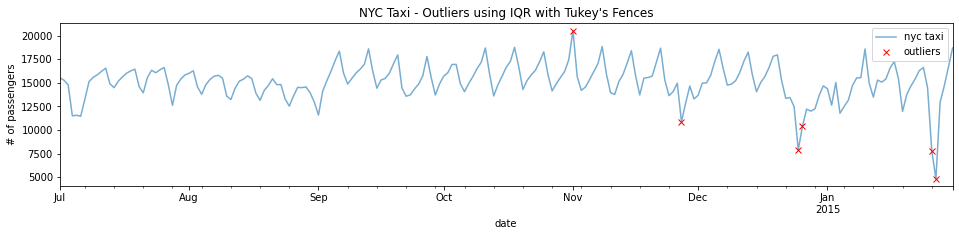

In [41]:
# Use the plot_outliers function defined earlier
plot_outliers(outliers, tx, "Outliers using IQR with Tukey's Fences")

The use of 1.5(IQR) is common when it comes to defining outliers! 

The choice is still arbitrary, we can change the value for more experimentation. In seaborn we can change the default 1.5 value by updating the "whis" parameter in the boxplot function. 

 - the choice of 1.5 makes the most sense when the data follows a Gaussian distribution (normal)
 - generally, the larger the value the fewer outliers we will capture as we expand our boundaries     (fences)

 - similarly, the smaller the value, the more non-outliers will be defined as outliers, as we are shrinking the boundaries 

 Let's update the _iqr_outliers_ function to accept a _p_ parameter so we can experiment with different values 


In [42]:
# Updating the iqr_outliers function 
def iqr_outliers(data, p): 
    q1, q3 = np.percentile(data, [25, 75])
    IQR = q3-q1 
    lower_fence = q1 - (p*IQR)
    upper_fence = q3 + (p*IQR)
    return data[(data.value > upper_fence) | (data.value < lower_fence)]


In [43]:
for p in [1.3, 1.5, 2.0, 2.5, 3.0]:
    print(f'with p={p}')
    print(iqr_outliers(tx, p))
    print('-'*15)
    

with p=1.3
                   value
timestamp               
2014-07-04  11511.770833
2014-07-05  11572.291667
2014-07-06  11464.270833
2014-09-01  11589.875000
2014-11-01  20553.500000
2014-11-08  18857.333333
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667
---------------
with p=1.5
                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667
---------------
with p=2.0
                   value
timestamp               
2014-11-01  20553.500000
2014-12-25   7902.125000
2015-01-26   7818.979167
2015-01-27   4834.541667
---------------
with p=2.5
                  value
timestamp              
2014-12-25  7902.125000
2015-01-26  7818.979167
2015-01-27  4834.541667
---------------
with p=3.0
                  value
timestamp              
2014-12-25  7902.125000
2015-01-26  78

## Detecting outliers using a z-score 

The z-score is a common transformation for standardizing the data. 

The z-score standardizes the data to be centered around a zero mean and the units represent standard deviations away from the mean

$z = \frac{x- \mu}{\sigma}$

where x is a data point and $\mu$ is the mean of the dataset, and $\sigma$ is the standard deviation for the dataset

The z-score is a lossless transformation, which means we will not lose information such as its distribution (shape of the data) or the relationship. All that is changing is the units of measurement as they are being scaled (standardized)

Once the data is transformed using the z-score, we can pick a threshold, so any data point above or below that threshold (in standard deviation) is considered an outlier. For example, the threshold ca nbe +3 and -3 standard deviations away from the mean. Any point lower than -3 or higher than +3 standard deviation can be considered an outlier. In other word, the further a point is from the mean, the higher the probability of it being an outlier 

The z-score has one majorshortcoming due to it being a parametric statistical method based on assumptions. It assumes a Gaussian (normal) distribution. So, suppose the data is not normal. In tha case, we will need to use a modified version of the z-score

In [45]:
# Create the zscore() function to standardize the data and filter out the extreme values based on a threshold

def zscore(df, degree=3):
    data = df.copy() 
    data['zscore'] = (data- data.mean())/data.std()
    outliers = data[(data['zscore'] <= -degree) | (data['zscore'] >= degree)]
    return outliers['value'], data 

In [46]:
# Use the zscore function and store the returned objects
threshold = 2.5 
outliers, transformed = zscore(tx, threshold)

array([[<AxesSubplot:title={'center':'value'}>,
        <AxesSubplot:title={'center':'zscore'}>]], dtype=object)

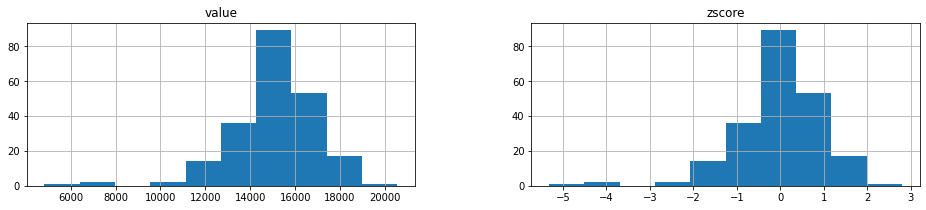

In [47]:
transformed.hist()

In [48]:
# Print the outliers 
print(outliers)

timestamp
2014-11-01    20553.500000
2014-12-25     7902.125000
2015-01-26     7818.979167
2015-01-27     4834.541667
Name: value, dtype: float64


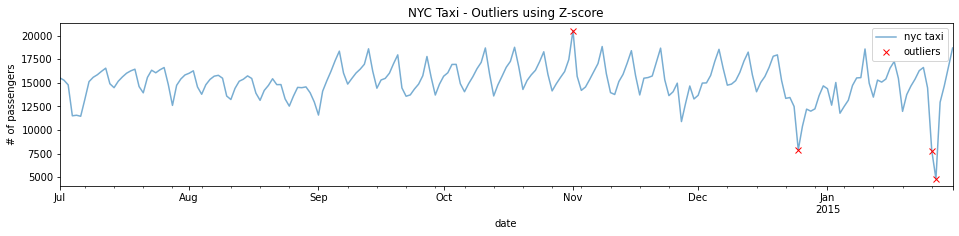

In [49]:
# Use the plot_outliers function defined earlier

plot_outliers(outliers, tx, "Outliers using Z-score")

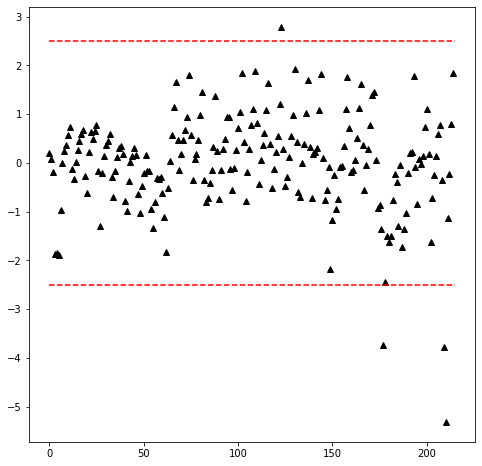

In [51]:
# Finally, we create a plot_zscore function that takes the standardized data to plot the data with the threshold lines

def plot_zscore(data, d=3):
    n=len(data)
    plt.figure(figsize=(8,8))
    plt.plot(data, 'k^')
    plt.plot([0,n], [d,d], 'r--')
    plt.plot([0,n], [-d,-d], 'r--')

# Run the function using a threshold of 2.5 
data = transformed['zscore'].values 
plot_zscore(data, d=2.5)


There are several tests available in the _statsmodels_ library to test if the data is normally distributed. One of these tests is the _Kolmogorov-Smirnov_ test. The null hypothesis is that the data
comes from a normal distribution. The test returns the test statistics and a p-value; if the p-value is less than 0.05, we can reject the null hypothesis (data is not normally distributed)

Otherwise, we would fail to reject the null hypothesis (data is normally distributed)

We will use the _kstest_normal_ function from the _statsmodels_ library. To make the results easier to interpret, create the _test_normal_ function below:


In [53]:
from statsmodels.stats.diagnostic import kstest_normal 
def test_normal(df):
    t_test, p_value = kstest_normal(df)
    if p_value < 0.05: 
        print("Reject null hypothesis. Data is not normal")
    else: 
        print("Fail to reject the null hypothesis. Data is normal")


test_normal(tx)

Reject null hypothesis. Data is not normal


## Detecting outliers using a modified z-score 

 - modifying the z-score to work with non-normal data
 - the main difference between the regular z-score and the modified z-score is that we replace the mean with the median

 Modified Z = $\frac{0.6745(x_{i} - \tilde{x})}{MAD}$

 Where $\tilde{x}$ is the median of the dataset, and MAD is the median absolute deviation of the dataset: 

 MAD = $median(abs(x_{i} - \tilde{x}))$

 The 0.6745 value is the standard deviation unit that corresponds to the 75th percentile in a Gaussian distribution and is used as a normalization factor. In other words, it is used to approximate the standard deviation. 

 We can obtain this value using SciPy's **percent point function (PPF)** also known as the inverse of the _cumulative distribution function (CDF)_ 

 Simply give the PPF function a percentile, for example 75%, and it will return the quantile corresponding to the lower tail probability


The modified z-score is sometimes referred to as the robust z-score! 

In [54]:
import scipy.stats as stats 
stats.norm.ppf(0.75)

0.6744897501960817

In [55]:
# Create the modified_zscore()

def modified_zscore(df, degree = 3):
    data = df.copy()
    s = stats.norm.ppf(0.75)
    numerator = s*(data - data.median())
    MAD = np.abs(data - data.median()).median()
    data['m_zscore'] = numerator/MAD 
    outliers = data[(data['m_zscore'] > degree) | (data['m_zscore'] < -degree)]
    return outliers['value'], data 


In [56]:
# Now, use the modified_zscore function and store the returned objects
threshold = 3 
outliers, transformed = modified_zscore(tx, threshold)


array([[<AxesSubplot:title={'center':'value'}>,
        <AxesSubplot:title={'center':'m_zscore'}>]], dtype=object)

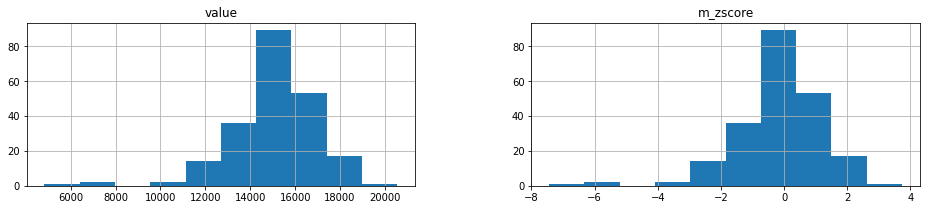

In [57]:
# To see the effect of the modified z-score transformation, we plot a histogram
transformed.hist()

In [58]:
# Run the modified_zscore function using a threshold of 3

print(outliers)

timestamp
2014-11-01    20553.500000
2014-11-27    10899.666667
2014-12-25     7902.125000
2014-12-26    10397.958333
2015-01-26     7818.979167
2015-01-27     4834.541667
Name: value, dtype: float64


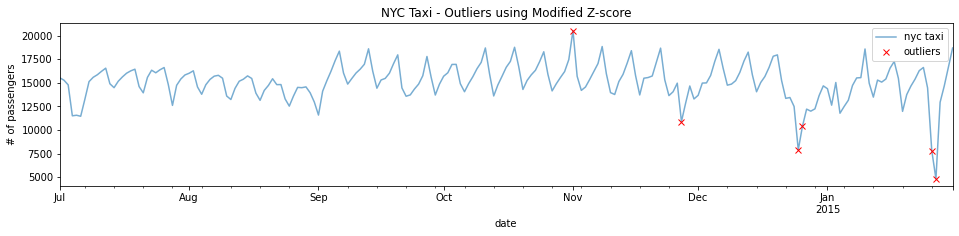

In [59]:
# Use the plot_outliers function defined earlier
plot_outliers(outliers, tx, "Outliers using Modified Z-score")


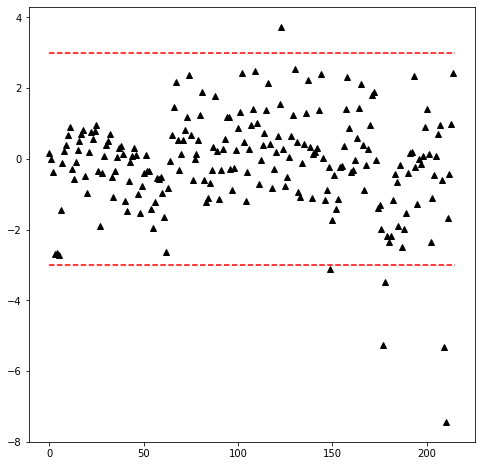

In [60]:
# Create a plot_m_zscore function that takes the standardized data to plot the data with the threshold lines
# this way we can visually see how the threshold is isolating extreme values

def plot_m_zscore(data, d=3):
    n = len(data)
    plt.figure(figsize=(8,8))
    plt.plot(data, 'k^')
    plt.plot([0,n], [d,d], 'r--')
    plt.plot([0,n], [-d,-d], 'r--')

data = transformed['m_zscore'].values 
plot_m_zscore(data, d=3)

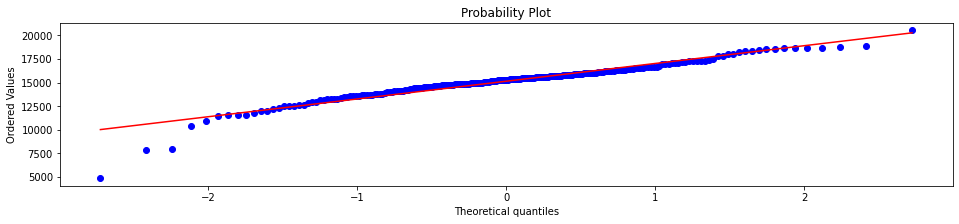

In [62]:
# QQ-plot 
# We can plot a QQ-plot using SciPy or statsmodels - borh will produce the same plot

import scipy 
res = scipy.stats.probplot(tx.values.reshape(-1), plot=plt)


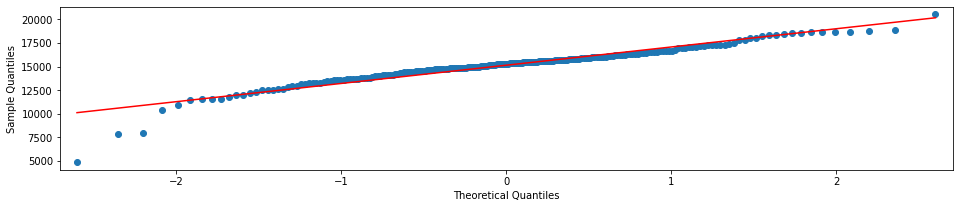

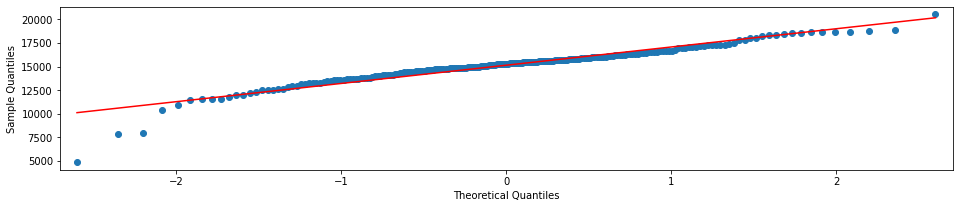

In [63]:
# This shows how we can plot using statsmodels: 

from statsmodels.graphics.gofplots import qqplot 
qqplot(tx.values.reshape(-1), line='s')
